In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange
import torch.nn as nn
import torch.nn.functional as F
# from lion_pytorch import Lion

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


In [3]:
tst_size = 20
trn, tst = data[:-tst_size], data[-tst_size:]

In [4]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_size:int=4, n_token:int=6):
    self.patch_size = patch_size
    #self.n_patch = 4
    self.n_patch = 12
    self.n_token = n_token
    self.window_size = int(patch_size * self.n_patch * n_token / 2)
    self.forecast_size = patch_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.window_size - self.forecast_size + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.window_size)]
    look_back = np.concatenate([look_back] + [look_back[-self.patch_size:]] * int(self.n_patch / 2))
    x = np.array([look_back[i*int(self.patch_size*self.n_patch/2):(i+2)*int(self.patch_size*self.n_patch/2)] for i in range(self.n_token)])

    y = self.data[(i+self.window_size):(i+self.window_size+self.forecast_size)]
    return x, y

In [5]:
#patch_size, n_patch, n_token = 4, 4, 6
patch_size, n_patch, n_token = 4, 12, 6
window_size = int(patch_size * n_patch * n_token / 2)

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, 4, 6)
tst_ds = PatchTSDataset(tst_scaled, 4, 6)

#trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=False) #한줄로 나옴
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True) 
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [6]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 6, 48]), torch.Size([32, 4]))

In [7]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
    return F.sigmoid(output)

In [8]:
model = PatchTST(n_token, patch_size * n_patch, 512, 8, 4, patch_size)
model.cuda()

#optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
#optim = Lion(model.parameters(), lr=0.001)

pbar = trange(500)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.cuda(), y.cuda()
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.cuda(), y.cuda()
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [21:23<00:00,  2.57s/it, loss=0.000168, tst_loss=0.00226]


In [9]:
def cal_mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def cal_mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

In [10]:
def cal_r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

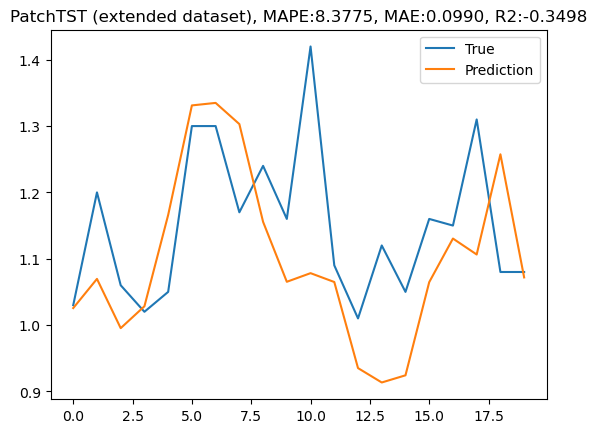

In [11]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.cuda(), y.cuda()
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

#plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.title(f"PatchTST (extended dataset), MAPE:{cal_mape(p,y):.4f}, MAE:{cal_mae(p,y):.4f}, R2:{cal_r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

In [12]:
#torch.save(model.state_dict(), "./model/model_adamW_patch12.pth")

(6, 48) (4,)
[0.6753623  0.6376811  0.6086956  0.6405797  0.62608695 0.63478255
 0.63478255 0.6463768  0.68405795 0.66376805 0.6811594  0.6289855
 0.6695652  0.7101449  0.7565217  0.76521736 0.70724636 0.6811594
 0.69275355 0.6869565  0.6405797  0.6956521  0.7855072  0.5797101
 0.6144927  0.59999996 0.69275355 0.6811594  0.62608695 0.65797096
 0.6463768  0.6405797  0.6492753  0.6985507  0.62608695 0.69275355
 0.63478255 0.60579705 0.6434782  0.7449275  0.7188406  0.7101449
 0.68405795 0.65507245 0.6869565  0.6985507  0.7188406  0.56811595
 0.6144927  0.59999996 0.69275355 0.6811594  0.62608695 0.65797096
 0.6463768  0.6405797  0.6492753  0.6985507  0.62608695 0.69275355
 0.63478255 0.60579705 0.6434782  0.7449275  0.7188406  0.7101449
 0.68405795 0.65507245 0.6869565  0.6985507  0.7188406  0.56811595
 0.6811594  0.66376805 0.6724638  0.63188404 0.66086954 0.66086954
 0.6376811  0.6492753  0.6405797  0.6753623  0.76231885 0.6782608
 0.7188406  0.6434782  0.7826087  0.7507246  0.6956521 

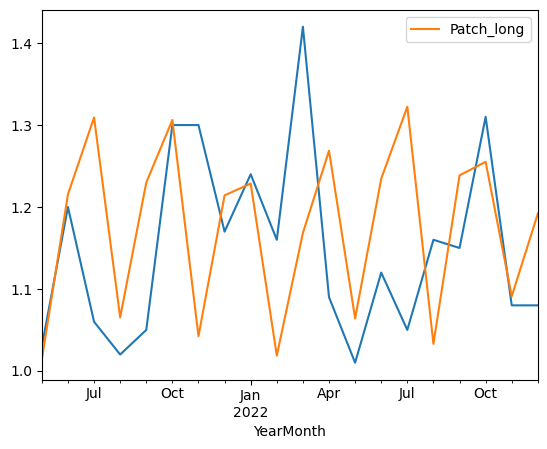

In [13]:
# 장기예측
window_size = 288
# window_size = 96
#window_size = 16
prediction_size = 4
#test_size=20
preds = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]

for _ in range(tst_size):
  #print(x, y)
  #y=y.squeeze()
  print(x.shape, y.shape) #(6,16),(4,)
  x = x.flatten()
  y = y.flatten()
  print(x, y)
  print(x.shape, y.shape) #(96,),(4,)

  x = np.concatenate([x,y])[-window_size:]
  x = x.reshape(1, n_token, -1) 
  print(x.shape)

  #
  #y = y.flatten()
  
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=model(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
print(preds.shape)
preds = preds[:,0]
print(preds.shape)


# 장기예측 plot
df = pd.DataFrame({"Patch_long": preds}, index=tst.index)
trn, tst = data.Temperature[:-20], data.Temperature[-20:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)


mape2 = cal_mape(preds,data.Temperature[-20:].to_numpy())
print("MAPE: ",mape2)
mae2 = cal_mae(preds,data.Temperature[-20:].to_numpy())
print("MAE: ",mae2)
r2_score2 = cal_r2_score(preds,data.Temperature[-20:].to_numpy())
print("R2_Score: ", r2_score2)


#torch.save(model.state_dict(), "./model/model_adamW_long_patch12.pth")